# Space-time dynamics


author: steeve.laquitaine@epfl.ch  
date: 2023.10.13  
last modified: 2023.10.13  
status:  OK
display-status: up-to-date  
regression: None  


## Setup

create and activate env from `npx_10m_384ch_unit_classes.txt`

In [2]:
# listen to changes
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np 
import spikeinterface as si

# set project path
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config
from src.nodes.load import load_campaign_params
from src.nodes.dataeng.silico import recording, probe_wiring
from src.nodes.prepro import preprocess
from src.nodes.truth.silico import ground_truth
from src.nodes.dataeng.lfp_only import stacking

# SETUP PARAMETERS
SAMPFREQ = 20000  # hz

# silico
data_conf, param_conf_sili = get_config(
    "silico_horvath", "concatenated/probe_2"
).values()
PREPRO_PATH = data_conf["preprocessing"]["output"]["trace_file_path"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
BOX_ASPECT = 1                  # square fig
LG_FRAMEON = False              # no legend frame
FIGSIZE = (6, 8)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 24
N_MAJOR_TICKS = 6
N_MINOR_TICKS = 12
YLIM = [1e-7, 1e10]
savefig_cfg = {"transparent":True}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}

2024-02-01 15:45:52,051 - root - utils.py - get_config - INFO - Reading experiment config.
2024-02-01 15:45:52,063 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Custom

In [3]:
def plot_probe(Recording):
    Probe = Recording.get_probe()

    # plot file contact with ids
    # fig, ax = plt.subplots(1, 1, figsize=(2, 10), mode="projection_3D")
    ax = plt.figure(figsize=(10, 20)).add_subplot(projection="3d")
    ax.view_init(0, -40, 0)
    ax.plot(
        Probe.contact_positions[:, 0],
        Probe.contact_positions[:, 1],
        Probe.contact_positions[:, 2],
        "o",
        markerfacecolor="w",
        color="k",
        markersize=6,
    )
    for ix in range(len(Probe.contact_positions)):
        if ix % 1 == 0:
            ax.text(
                Probe.contact_positions[ix, 0],
                Probe.contact_positions[ix, 1],
                Probe.contact_positions[ix, 2],
                "%s" % (str(Probe.contact_ids[ix])),
                size=12,
                zorder=100,
                color="r",
            )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)

    # highlight order
    # first site
    ax.plot(
        Probe.contact_positions[0, 0],
        Probe.contact_positions[0, 1],
        Probe.contact_positions[0, 2],
        "ro",
        markersize=10,
    )

    # highlight order
    # second site
    ax.plot(
        Probe.contact_positions[1, 0],
        Probe.contact_positions[1, 1],
        Probe.contact_positions[1, 2],
        "bo",
        markersize=10,
    )

    # highlight order
    # third site
    ax.plot(
        Probe.contact_positions[2, 0],
        Probe.contact_positions[2, 1],
        Probe.contact_positions[2, 2],
        "go",
        markersize=10,
    )
    ax.set_box_aspect((1, 16, 16))

### Preprocessed traces

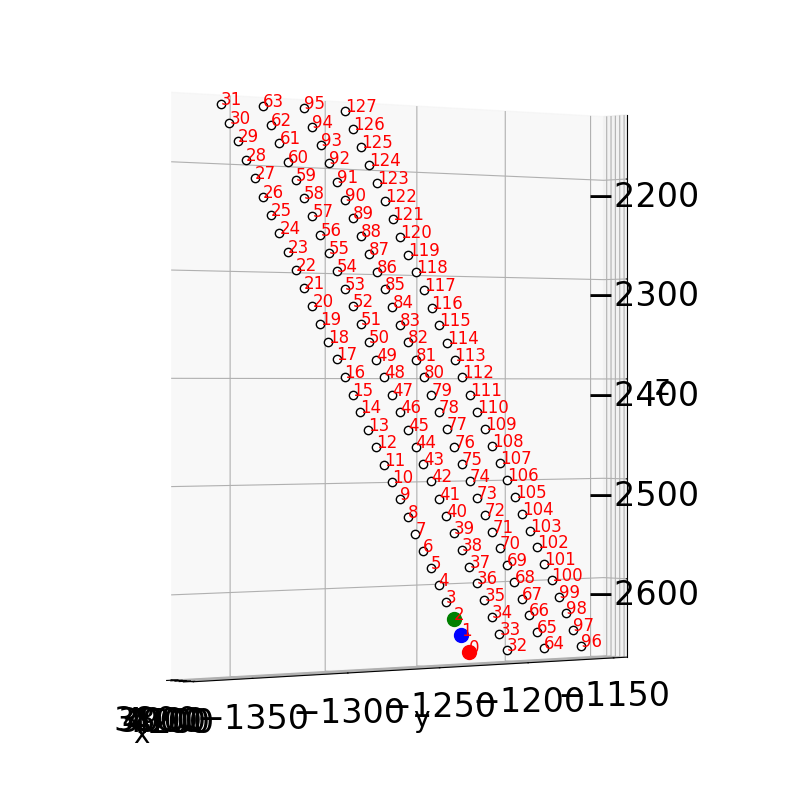

In [4]:
# get preprocessed
Recording = si.load_extractor(PREPRO_PATH)

# get layers
layers = Recording.get_property("layers")

# count site per column
site_per_col = int(len(layers) / 4)

# get layers layout
col1_site_out = np.where(layers[:site_per_col] == "Outside")[0]
col1_site_l1 = np.where(layers[:site_per_col] == "L1")[0]
col1_site_l2_3 = np.where(
    (layers[:site_per_col] == "L2") | (layers[:site_per_col] == "L3")
)[0]
col1_site_l4 = np.where(layers[:site_per_col] == "L4")[0]
col1_site_l5 = np.where(layers[:site_per_col] == "L5")[0]
col1_site_l6 = np.where(layers[:site_per_col] == "L6")[0]

plot_probe(Recording)

In [5]:
len(col1_site_l5)

22

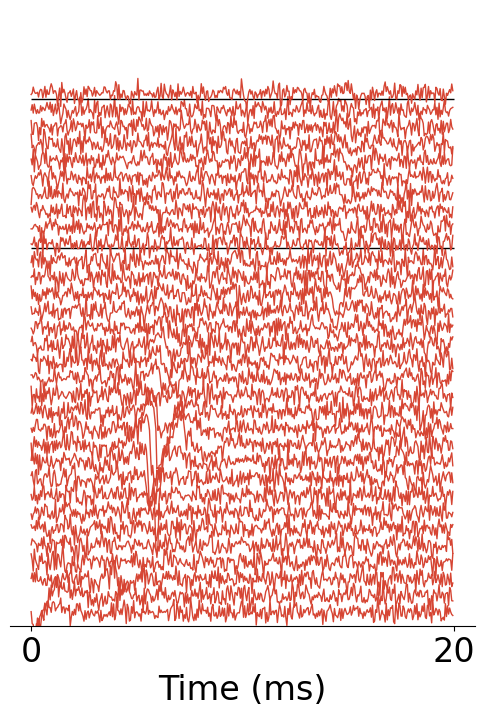

In [6]:
# takes 5 secs

# plot
NUM = 1400  # 1400, 76, 1200, 10, 14, 46, 53, 61, 500,
LINEWIDTH = 1
PLOT_Y_PITCH = 100
DURATION = 20  # 20  # in ms, 46
n_timepoints = int(DURATION * SAMPFREQ / 1000)
PERIOD = np.arange((NUM - 1) * n_timepoints, NUM * n_timepoints, 1)
Y_MAX = PLOT_Y_PITCH * (site_per_col - 1)

prep_traces = Recording.get_traces()
n_contacts = prep_traces.shape[1]

# plot 384 contacts x 5 ms (like Trautmann et al 2023)

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0
for contact_i in np.arange(0, site_per_col, 1):
    # mark the first trace of each layer
    # layer 5
    # if contact_i == col1_site_l5[0]:
    #     ax.hlines(
    #         y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
    #     )

    # layer 4
    if contact_i == col1_site_l4[0]:
        ax.hlines(
            y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # layer 2/3
    if contact_i == col1_site_l2_3[0]:
        ax.hlines(
            y=0.99 * pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1
        )

    # Outside
    if contact_i == 73:
        ax.hlines(y=pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=1)

    # all other traces
    else:
        ax.plot(
            prep_traces[PERIOD, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_SILI,
        )
    pos_up += PLOT_Y_PITCH

ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, 20])
ax.set_xlabel("Time (ms)")
ax.set_ylim([-80, Y_MAX + 500])
plt.yticks([])

# save figures
plt.savefig(
    "figures/2_realism/2_dynamics/pdf/horvath/silico_horvath_dynamics.pdf",
    **savefig_cfg
)
plt.savefig(
    "figures/2_realism/2_dynamics/svg/horvath/silico_horvath_dynamics.svg",
    **savefig_cfg
)